In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from enum import Enum
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import numpy as np
import pickle
from enum import Enum

In [ ]:
from google.colab import drive
drive.mount('/content/cdrive')
data_root_dir = 'cdrive/MyDrive/Deep Learning//'

Mounted at /content/cdrive


# set seed


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
seed=0

# data preprocessing


## choose your dataset!

In [ ]:
class DatasetEnum(Enum):
   FashionMNIST = 0
   MNIST = 1

dataset_type = DatasetEnum.MNIST

In [ ]:
vae_batch_size = 128

# FASHION MNIST / MNIST  DATASET
transform = transforms.Compose([transforms.ToTensor(), torch.flatten])

if dataset_type is DatasetEnum.FashionMNIST:
  trainset = datasets.FashionMNIST(root=data_root_dir, train=True, download=True, transform=transform)
  evalset = datasets.FashionMNIST(root=data_root_dir, train=False, download=True, transform=transform)
elif dataset_type is DatasetEnum.MNIST:
  trainset = datasets.MNIST(root=data_root_dir, train=True, download=True, transform=transform)
  evalset = datasets.MNIST(root=data_root_dir, train=False, download=True, transform=transform)
else:
  raise ValueError("wrong dataset type")

vae_train_loader = torch.utils.data.DataLoader(trainset, batch_size=vae_batch_size, shuffle=True)
eval_loader = torch.utils.data.DataLoader(evalset, batch_size=len(evalset), shuffle=False)

for X_test, y_test in eval_loader:
  pass

y_test = y_test.numpy()

# VAE model

In [ ]:
NUM_HIDDEN_UNITS = 600
LATENT_SIZE      = 50

class VaeEncoder(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.ModuleList([
                                  nn.Linear(in_features=input_dim, out_features=NUM_HIDDEN_UNITS),
                                  nn.Softplus(),
                                  nn.Linear(in_features=NUM_HIDDEN_UNITS, out_features=NUM_HIDDEN_UNITS),
                                  nn.Softplus()
                                  ])

    self.output_mean = nn.Linear(in_features=NUM_HIDDEN_UNITS, out_features=LATENT_SIZE)
    self.output_logvar = nn.Linear(in_features=NUM_HIDDEN_UNITS, out_features=LATENT_SIZE)

  def forward(self, x):
    for f in self.layers:
      x = f(x)
    return self.output_mean(x), self.output_logvar(x)

class VaeDecoder(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.ModuleList([
                                  nn.Linear(in_features=LATENT_SIZE, out_features=NUM_HIDDEN_UNITS),
                                  nn.Softplus(),
                                  nn.Linear(in_features=NUM_HIDDEN_UNITS, out_features=NUM_HIDDEN_UNITS),
                                  nn.Softplus(),
                                  nn.Linear(in_features=NUM_HIDDEN_UNITS, out_features=input_dim),
                                  nn.Sigmoid()
                                  ])
  def forward(self, z_mean, z_logvar):
    eps = torch.randn_like(z_mean)
    z_init = z_mean + torch.exp(0.5 * z_logvar) * eps
    x_recon = z_init
    for f in self.layers:
      x_recon = f(x_recon)
    return x_recon, z_init

class VAE(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.encoder = VaeEncoder(input_dim)
    self.decoder = VaeDecoder(input_dim)

    self.init_weights(self.encoder)
    self.init_weights(self.decoder)

  def forward(self, x):
    z_mean, z_logvar = self.encoder(x)
    x_recon, z_rand = self.decoder(z_mean, z_logvar)
    return x_recon, z_mean, z_logvar, z_rand

  def init_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.001)
        nn.init.constant_(m.bias, 0)


In [ ]:
def vae_loss(x, xhat, z_mean, z_logvar):
  """
  Variational Autoencoder loss term composed of:
    1. Reconstruction loss: J = L(x, D(E(x)))
    2. Regularization loss: Measurement of the KLD to the N(0, 1) distribution

  The regularization term is weighted to give preference to reconstruction which
  tends to be more important.
  """
  # multiply by number of entries in x to use sum instead of mean (only mean on the batch dim)
  # reconstruction_loss = x.size()[0] * x.size()[1] * nn.functional.binary_cross_entropy(xhat, x)
  binary_cross_entropy = torch.nn.BCELoss(weight=None, size_average=None, reduce=None,reduction='sum')
  reconstruction_loss = binary_cross_entropy(xhat, x)
  kl = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp(), axis= -1)
  return reconstruction_loss + kl.mean()

# svm utils

In [ ]:
def get_indices_per_classes(dataset):
  # Create indices for each class
  class_indices = {}
  for idx, (image, label) in enumerate(dataset):
    if label not in class_indices:
      class_indices[label] = []
    class_indices[label].append(idx)

  return class_indices

def sample_labelled_subset(trainset, indices_per_class, n_samples):
  n_classes = len(indices_per_class)
  samples_per_class = n_samples // n_classes

  # Sample equal number of samples from each class
  sampled_indices = []
  for label, indices in indices_per_class.items():
      sampled_indices.extend(indices[:samples_per_class])

  subset_train_dataset = torch.utils.data.Subset(trainset, sampled_indices)
  subset_dataloader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=n_samples, shuffle=False)
  return subset_dataloader

def save_svm(clf, clf_name, n_samples, dataset_type: DatasetEnum):
  if dataset_type is DatasetEnum.FashionMNIST:
    filename = data_root_dir + f"saved_models/{clf_name}_{n_samples}_labels.pkl"
  elif dataset_type is DatasetEnum.MNIST:
    filename = data_root_dir + f"saved_models/MNIST_{clf_name}_{n_samples}_labels.pkl"
  with open(filename, 'wb') as f:
    pickle.dump(clf, f)

def load_svm(clf_name, n_samples, dataset_type: DatasetEnum):
  if dataset_type is DatasetEnum.FashionMNIST:
    filename = data_root_dir + f"saved_models/{clf_name}_{n_samples}_labels.pkl"
  elif dataset_type is DatasetEnum.MNIST:
    filename = data_root_dir + f"saved_models/MNIST_{clf_name}_{n_samples}_labels.pkl"
  with open(filename, 'rb') as f:
    clf = pickle.load(f)
  return clf

# hyper-params


In [ ]:
n_epochs = 100
input_dim = trainset[0][0].reshape(-1).shape[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VAE training

In [ ]:

vae_model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0003, weight_decay=0.01)
# binary_cross_entropy = torch.nn.BCELoss(weight=None, size_average=None, reduce=None,reduction='sum')

# VAE training
for epoch in range(n_epochs):
  vae_model.train()
  epoch_loss = 0
  for xi, _ in vae_train_loader:
    xi = xi.to(device)

    # treat pixel intensities as bernoulli distributions
    p_xi = torch.bernoulli(xi)
    vae_model.zero_grad()

    # forward
    p_theta_x_z, mu, logvar, _ = vae_model(p_xi)

    batch_loss = vae_loss(p_xi, p_theta_x_z, mu, logvar)

    batch_loss.backward()
    optimizer.step()

    epoch_loss += batch_loss.item()

  epoch_loss = epoch_loss / (len(vae_train_loader))
  if epoch == 0 or (epoch+1) % 5 == 0:
    print(f'E[{epoch + 1}/{n_epochs}]: L={epoch_loss:.4f}')



In [ ]:
# save model weights
torch.save({
    'epoch': epoch+1,
    'model_state_dict': vae_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, data_root_dir + f'saved_models/VAE_MNIST_chkpt_epoch_{epoch+1}')

# SVM fitting


In [ ]:
if dataset_type is DatasetEnum.FashionMNIST:
  chkpt = torch.load(data_root_dir + f'saved_models/VAE_chkpt_epoch_{n_epochs}_fixed_kl', map_location=torch.device(device))
elif dataset_type is DatasetEnum.MNIST:
  chkpt = torch.load(data_root_dir + f'saved_models/VAE_MNIST_chkpt_epoch_{n_epochs}', map_location=torch.device(device))
else:
  raise ValueError("wrong dataset type")
# load vae
vae_model = VAE(input_dim).to(device)
vae_model.load_state_dict(chkpt['model_state_dict'])


<All keys matched successfully>

In [ ]:
vae_model.eval()
_, Z_test, _, _ = vae_model(X_test.to(device))
X_test_numpy = X_test.detach().cpu().numpy()
#  to cpu & numpy
Z_test = Z_test.detach().cpu().numpy()

# set number of labelled samples
num_labelled_samples = [100, 600, 1000, 3000]

# Calculate class indices for the trainset (to perform balanced sampling)
indices_per_class = get_indices_per_classes(trainset)

for n_labelled in num_labelled_samples:
  svm_train_loader =  sample_labelled_subset(trainset, indices_per_class, n_labelled)

  # SVM training
  latent_svm = SVC(kernel='rbf', random_state=seed)
  reg_svm = SVC(kernel='rbf', random_state=seed)

  # get labelled data
  svm_train_batch = next(iter(svm_train_loader))
  xi, yi = svm_train_batch

  # generate latent representation
  p_theta_x_z, zi , _, _  = vae_model(xi.to(device))

  #  to cpu & numpy
  xi = xi.detach().cpu().numpy()
  zi = zi.detach().cpu().numpy()
  yi = yi.numpy()

  # fit
  latent_svm.fit(zi, yi)
  y_hat_latent = latent_svm.predict(Z_test)

  reg_svm.fit(xi, yi)
  y_hat_reg = reg_svm.predict(X_test)

  err_rate_latent = 100 * np.sum(y_hat_latent != y_test) / Z_test.shape[0]
  err_rate_reg = 100 * np.sum(y_hat_reg != y_test) / X_test.shape[0]

  print(f"train set samples: {n_labelled}, vanilla svm error rate: {err_rate_reg}%, VAE + svm error rate: {err_rate_latent}%")
  # save svm clf
  save_svm(latent_svm, "M1_svm", n_labelled, dataset_type)
  save_svm(reg_svm, "vanilla_svm", n_labelled, dataset_type)



train set samples: 100, vanilla svm error rate: 30.69%, VAE + svm error rate: 20.09%
train set samples: 600, vanilla svm error rate: 11.25%, VAE + svm error rate: 6.58%
train set samples: 1000, vanilla svm error rate: 9.04%, VAE + svm error rate: 5.28%
train set samples: 3000, vanilla svm error rate: 5.84%, VAE + svm error rate: 2.92%


# Evaluation

In [ ]:
if dataset_type is DatasetEnum.FashionMNIST:
  chkpt = torch.load(data_root_dir + f'saved_models/VAE_chkpt_epoch_{n_epochs}_fixed_kl', map_location=torch.device(device))
elif dataset_type is DatasetEnum.MNIST:
  chkpt = torch.load(data_root_dir + f'saved_models/VAE_MNIST_chkpt_epoch_{n_epochs}', map_location=torch.device(device))
else:
  raise ValueError("wrong dataset type")
# load vae
vae_model = VAE(input_dim).to(device)
vae_model.load_state_dict(chkpt['model_state_dict'])

vae_model.eval()
X_recon_test, Z_test, _, _ = vae_model(X_test.to(device))
#  to cpu & numpy
Z_test = Z_test.detach().cpu().numpy()

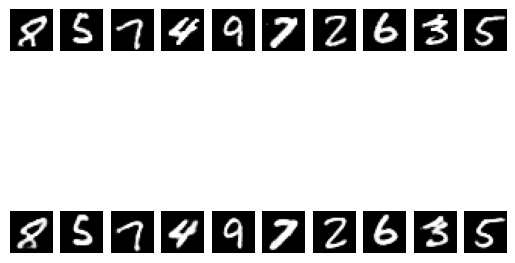

In [ ]:
n = 10
n_examples = torch.randint(X_test.shape[0], (n,))

for i in range(n):
  plt.subplot(2, n, i+1)
  # plt.imshow(xi[i].reshape(28, 28).detach().cpu(), cmap='gray')
  plt.imshow(X_test[n_examples[i]].reshape(28, 28), cmap='gray')
  plt.axis('off')

  plt.subplot(2, n, i+n+1)
  plt.imshow(X_recon_test[n_examples[i]].reshape(28, 28).detach().cpu(), cmap='gray')
  plt.axis('off')

In [ ]:
# set number of labelled samples
num_labelled_samples = [100, 600, 1000, 3000]

# load svms and evaluate
for n_labelled in num_labelled_samples:
  # load corresponding svm
  m1_svm = load_svm("M1_svm", n_labelled, dataset_type)
  vanilla_svm = load_svm("vanilla_svm", n_labelled, dataset_type)

  # predict for the testset
  y_hat_m1 = m1_svm.predict(Z_test)
  y_hat_vanilla = vanilla_svm.predict(X_test)

  test_err_rate_m1 = 100 * np.sum(y_hat_m1 != y_test) / len(y_test)
  test_err_rate_vanilla = 100 * np.sum(y_hat_vanilla != y_test) / len(y_test)

  print(f"train set size: {n_labelled}")
  print(f"test error rate: Vanilla SVM - {test_err_rate_vanilla}%, M1 + SVM - {test_err_rate_m1}%")
  print(f"")


train set size: 100
test error rate: Vanilla SVM - 30.69%, M1 + SVM - 20.09%

train set size: 600
test error rate: Vanilla SVM - 11.25%, M1 + SVM - 6.58%

train set size: 1000
test error rate: Vanilla SVM - 9.04%, M1 + SVM - 5.28%

train set size: 3000
test error rate: Vanilla SVM - 5.84%, M1 + SVM - 2.92%

